# Initial processing and visualisation of calcification data

Currently only using my spreadsheet. Initial look at data and methods to fit calcification rates wrt some independent variable.

Some notes, upon reviewing the [PNAS paper](https://www.pnas.org/doi/full/10.1073/pnas.2015265118):

1. Climate models
    - Higher-resolution (0.25º rather than 1º) from CMIP6
    - Factor in ensemble uncertainty rather than simply taking mean
2. Non-linear relationships: a number of papers show a parabolic relationship? This could show increase then decrease in net calcification over time/space
3. Meta summary statistics
    - Total number of studies, total number of datapoints
    - Number of responses per intervention
    - Proportion of locations (by number of surveys, by number of samples)
    - Don’t have reef type consistently between studies, but this *is* a subset of studies. This could be an interesting comparison, but may be getting too complex
    - Quantify different types of studies e.g. ocean acidification and X calcification, N interactive effects etc.
4. Plot decline in NCP as a function of time (if using several timesteps): year in which it switches from production to erosion (perhaps by ocean basin)
5. Reef accretion rates relative to sea level rise
    - PNAS uses mean sea level rise (which alone is pretty catastrophic), but given spatial variability in sea level rise would be interesting to compare spatially to find the biggest losers.
6. What rates are we taking into account? e.g. sediment dissolution rates still assumed to match those measured on lagoon sediments? (unlikely given variability of flushing)
7. “some shallower reefs may actually benefit from rising sea levels, with increasing accommodation space allowing for increased coral vertical growth (40). Indeed, this has been observed in the past (41) during much slower rates of sea level rise. It is unknown whether these possible gains in accretion will outweigh losses due to ocean warming and acidification, but determining when and where this could occur should be an urgent focus for future research” – outside scope of this paper, but interesting!
8. QA questions:
    - “we do not include Halimeda spp. in our model because of the unclear nature of its eventual contribution to reef accretion and because of the larger uncertainty regarding the impacts of ocean acidification and warming on its calcification that was observed during our surveys of the literature.” –Same this time round?
        - Measure species-wise variation in calcification? i.e. these would just be messy plots of response vs variables
    2. “Seawater carbonate chemistry was recalculated in some studies where inconsistencies were found between pH scales”
        - When to recalculate seawater chemistry?
    3. Convert from NBS to Total
        - “Studies using the National Bureau of Standards scale were converted to the total scale (hereafter "pH") using the excel macro CO2sys (51) and method following ref. 52” – I can do this better with cybsyst
    4. “Research examining the effects of ocean acidification were excluded if they did not present standardized measurements of seawater carbonate chemistry that could allow us to accurately determine pH on the total scale (53).”
    5. Extra rates
        - Did I include bioerosion?
        - Sediment production?
7. Environmental variables:
    - Pretty rule of thumb for DHW metric (can perhaps do better): “we assume that if a coral reef community suffers two or more marine heatwaves of a certain DHW extent within one decade, these events will not allow them to recover to their original coral cover.”


In [15]:
### autoreload
%reload_ext autoreload
%autoreload 2

### imports
# general
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# custom
from calcification import utils, plotting, config, analysis
from cbsyst import helpers as cbh

In [16]:
out = pd.read_excel(
    config.data_dir / "Orlando_data.xlsx",
    sheet_name="all_data",
)
out[out.Include == 'yes']

,Extractor,Notes,Secondary check,Include,Authors,DOI,Year,Species types,Taxa,Location,...,Calcification,Calcification se,Calcification sd,Calcification units,Duration,Methods,Notes+,Notes++,Unnamed: 64,Unnamed: 65
0,Orlando,NaN,1,yes,Bergstrom E.; Lahnstein J.; Collins H.; Page T...,10.1111/jpy.13290,2023.0,Porolithon cf onkodes,Algae,"Lizard Island, GBR, Australia",...,1.970803,0.255550,NaN,mg cm-2day-1,NaN,NaN,NaN,NaN,NaN,NaN
1,Orlando,NaN,1,yes,NaN,NaN,NaN,Porolithon cf onkodes,Algae,"Lizard Island, GBR, Australia",...,2.408759,0.189760,NaN,mg cm-2day-1,NaN,NaN,NaN,NaN,NaN,NaN
2,Orlando,NaN,1,yes,NaN,NaN,NaN,Porolithon cf onkodes,Algae,"Lizard Island, GBR, Australia",...,1.664234,0.167864,NaN,mg cm-2day-1,NaN,NaN,NaN,NaN,mg cm-2day-1,NaN
3,Orlando,NaN,1,yes,NaN,NaN,NaN,Porolithon cf onkodes,Algae,"Lizard Island, GBR, Australia",...,1.839416,0.124074,NaN,mg cm-2day-1,NaN,NaN,NaN,NaN,mg g-1day-1,NaN
4,Orlando,NaN,1,yes,NaN,NaN,NaN,Lithophyllum cf insipidum,Algae,"Lizard Island, GBR, Australia",...,1.467626,0.131372,NaN,mg cm-2day-1,NaN,NaN,NaN,NaN,%changeCaCO3 day-1 (relative to initial mass),NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6988,Cornwall,NaN,0,yes,Vasquez-Elizondo and Enriquez,NaN,2016.0,Neogoniolithon sp.,CCA,"reef lagoon, Puerto Morelos, Mexico, Caribbean",...,-0.03,0.040000,NaN,NaN,13,NaN,NaN,NaN,NaN,NaN
6989,Cornwall,NaN,0,yes,Venn et al. 2013,10.1073/pnas.0902894106,2009.0,Stylophora pistillata,Coral,"Aquarium, Mediterranean",...,482,138.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6990,Cornwall,NaN,0,yes,Venn et al. 2013,NaN,2009.0,Stylophora pistillata,Coral,"Aquarium, Mediterranean",...,450,114.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6991,Cornwall,NaN,0,yes,Venn et al. 2013,NaN,2009.0,Stylophora pistillata,Coral,"Aquarium, Mediterranean",...,334,159.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# TODO: profile this and potentially refactor for speed
effects_df = analysis.calculate_effect_sizes_end_to_end(
    raw_data_fp=config.data_dir / 'Orlando_data.xlsx',
    data_sheet_name='all_data',
    climatology_data_fp=config.climatology_data_dir / 'site_locations_with_MMM_and_pH.csv',
    selection_dict={'include': 'yes'},
)


Duplicate DOIs found, treat with caution:
['10.4319/lo.2014.59.3.1081', '10.1111/gcb.14379', '10.1016/j.jembe.2013.12.013', '10.1007/s00338-016-1425-0', '10.1007/s00227-012-2001-y']
Using locations in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/gmaps_locations.yaml
Using species mapping in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/species_mapping.yaml.
Loading measured values...
1: (3394, 82)
2: (7035, 66)
3: (3547, 64)
Calculating total pH values...
4: (3547, 64)
5: (3547, 64)
6: (3547, 33)


Calculating carbonate chemistry:   0%|          | 0/3547 [00:00<?, ?it/s]

7: (3547, 33)

Shape of dataframe with all rows marked for inclusion: (3547, 82)

Calculating effect sizes...


  0%|          | 0/163 [00:00<?, ?it/s]


Shape of dataframe with effect sizes: (1284, 104)


# ...now aligning with climatology

In [20]:
def convert_climatology_csv_to_multiindex(fp: str, locations_yaml_fp: str) -> pd.DataFrame:
    """
    Convert the climatology CSV file to a multi-index DataFrame.
    """
    df = pd.read_csv(fp).drop(columns=['data_ID', 'Unnamed: 0']).set_index('doi')
    # rename columns to be less wordy
    df = df.replace(
        {"2021_2040": 2040,
        "2041_2060": 2060,
        "2081_2100": 2100}
        ).infer_objects(copy=False)
    
    var = 'ph' if 'ph' in str(fp.name) else 'sst' if 'sst' in str(fp.name) else None
    if not var:
        raise ValueError("File path must contain 'ph' or 'sst' to determine variable type.")
    df = pd.concat([df.iloc[:, :4], df.iloc[:, 4:].rename(columns=lambda col: col if var in col else f'{var}_{col}')], axis=1)

    # load locations yaml as dataframe
    locations_fp = config.resources_dir / 'locations.yaml'
    locations_df = pd.DataFrame(utils.read_yaml(locations_fp)).T
    # reorder columns to be latitude, longitude, location
    locations_df = locations_df[['latitude', 'longitude', 'location']]

    # merge locations with sst_df
    df = df.merge(locations_df, left_index=True, right_index=True, how='left', suffixes=('', '_right'))
    df = df.loc[:, ~df.columns.str.endswith('_right')]
    df.reset_index(inplace=True, names='doi')
    
    return df

ph_climatology = convert_climatology_csv_to_multiindex(
    config.climatology_data_dir / "ph_scenarios_output_table_site_locations.csv",
    config.resources_dir / 'locations.yaml')

sst_climatology = convert_climatology_csv_to_multiindex(
    config.climatology_data_dir / "sst_scenarios_output_table_site_locations.csv",
    config.resources_dir / 'locations.yaml')

# concatenated sst and ph climatology dataframes
merged_clim_df = pd.merge(
    sst_climatology,
    ph_climatology,
)

# set multiindex
merged_clim_df_mi = merged_clim_df.set_index(['doi', 'location', 'longitude', 'latitude'])

/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_35399/1349378119.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(
/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_35399/1349378119.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(


In [21]:
effects_df_mi = effects_df.set_index(['doi', 'location', 'longitude', 'latitude'])
effects_clim_df = effects_df_mi.join(merged_clim_df_mi, how='inner')
effects_clim_df.head()

authors  \
doi               location                      longitude  latitude                                                        
10.1111/jpy.13290 Lizard Island, GBR, Australia 145.459236 -14.692278  Bergstrom E.; Lahnstein J.; Collins H.; Page T...   
                                                           -14.692278  Bergstrom E.; Lahnstein J.; Collins H.; Page T...   
                                                           -14.692278  Bergstrom E.; Lahnstein J.; Collins H.; Page T...   
                                                           -14.692278  Bergstrom E.; Lahnstein J.; Collins H.; Page T...   
                                                           -14.692278  Bergstrom E.; Lahnstein J.; Collins H.; Page T...   

                                                                       calcification  \
doi               location                      longitude  latitude                    
10.1111/jpy.13290 Lizard Island, GBR, Australia 145.459236 -14.692278       1.457143   
                                                           -14.692278       1.457143   
                                                           -14.692278       1.457143   
                                                           -14.692278       1.457143   
                                                           -14.692278       1.457143   

                                                                       calcification_sd  \
doi               location                      longitude  latitude                       
10.1111/jpy.13290 Lizard Island, GBR, Australia 145.459236 -14.692278          0.130559   
                                                           -14.692278          0.130559   
                                                           -14.692278          0.130559   
                                                           -14.692278          0.130559   
                                                           -14.692278          0.130559   

                                                                       calcification_se  \
doi               location                      longitude  latitude                       
10.1111/jpy.13290 Lizard Island, GBR, Australia 145.459236 -14.692278          0.058388   
                                                           -14.692278          0.058388   
                                                           -14.692278          0.058388   
                                                           -14.692278          0.058388   
                                                           -14.692278          0.058388   

                                                                      calcification_unit  \
doi               location                      longitude  latitude                        
10.1111/jpy.13290 Lizard Island, GBR, Australia 145.459236 -14.692278       mg cm-2day-1   
                                                           -14.692278       mg cm-2day-1   
                                                           -14.692278       mg cm-2day-1   
                                                           -14.692278       mg cm-2day-1   
                                                           -14.692278       mg cm-2day-1   

                                                                                                          cleaned_coords  \
doi               location                      longitude  latitude                                                        
10.1111/jpy.13290 Lizard Island, GBR, Australia 145.459236 -14.692278  14°41′17.4′′S, 145°28′03.6′′E / 14°41′47.0′′S,...   
                                                           -14.692278  14°41′17.4′′S, 145°28′03.6′′E / 14°41′47.0′′S,...   
                                                           -14.692278  14°41′17.4′′S, 145°28′03.6′′E / 14°41′47.0′′S,...   
                                                           -14.692278  14°41′17.4′′S, 

In [22]:
# length of complete effects_df - number of rows not matching up with sst_df, multiplied by number of sst rows per effect row
expected_num = (len(effects_df_mi) - len(set(effects_df_mi.index).difference(set(merged_clim_df_mi.index)))) * 12
actual_num = len(effects_clim_df)

print(f"Expected number of rows: {expected_num}")
print(f"{expected_num-actual_num}-row anomaly between climatology and effects dataframes")

Expected number of rows: 14928
3084-row anomaly between climatology and effects dataframes


In [23]:
# ### plot a scatter of multivariate hedges_g against delta_t
# fig, ax = plt.subplots(figsize=(12, 8))

# # add error bars
# ax.errorbar(effects_clim_df['delta_t'], effects_clim_df['hedges_g'], yerr=effects_clim_df['hedges_g_var'], fmt='o', color='black', alpha=0.5)
# ax.scatter(effects_clim_df['delta_t'], effects_clim_df['hedges_g'], zorder=10, alpha=0.8)

# ax.set_ylim([min(effects_clim_df['hedges_g']), max(effects_clim_df['hedges_g'])])

# scenarios = effects_clim_df.scenario.unique()
# colors = sns.color_palette("Reds", len(scenarios))

# for i, scenario in enumerate(scenarios):
#     scenario_df = effects_clim_df[effects_clim_df.scenario == scenario]
#     # plot a vertical line at the global average historic temperature
#     ax.vlines(x=scenario_df.mean_sst_20y_anomaly_ensemble.mean(), ymin=min(effects_clim_df['hedges_g']), ymax=max(effects_clim_df['hedges_g']), color=colors[i], linestyle='--', label=scenario, zorder=100)
#     # add shaded area corresponding to +- 1 standard deviation
#     # ax.fill_betweenx(y=[min(effects_clim_df['hedges_g']), max(effects_clim_df['hedges_g'])], x1=scenario_df.mean_sst_20y_anomaly_ensemble.mean() - scenario_df.mean_sst_20y_anomaly_ensemble.std(), x2=scenario_df.mean_sst_20y_anomaly_ensemble.mean() + scenario_df.mean_sst_20y_anomaly_ensemble.std(), color=colors[i], alpha=0.1, zorder=99)

# ax.hlines(y=0, xmin=min(effects_clim_df['delta_t']*1.1), xmax=max(effects_clim_df['delta_t'])*1.1, color='black', linestyle='-', label='No effect')
# ax.set_xlabel('Temperature Anomaly (°C)')
# ax.set_ylabel('Hedges g')
# ax.set_xlim([min(effects_clim_df['delta_t']*1.1), max(effects_clim_df['delta_t'])*1.1])
# ax.legend(loc="lower right")

# # plot a second-order polynomial fit
# # remove nans
# effects_clim_df = effects_clim_df[effects_clim_df['delta_t'].notna()]
# z = np.polyfit(effects_clim_df['delta_t'], effects_clim_df['hedges_g'], 2)
# xp = np.linspace(min(effects_clim_df['delta_t']), max(effects_clim_df['delta_t']), 100)
# p = np.polyval(z, xp)
# ax.plot(xp, p, color='red', label='2nd order polynomial fit', zorder=101)

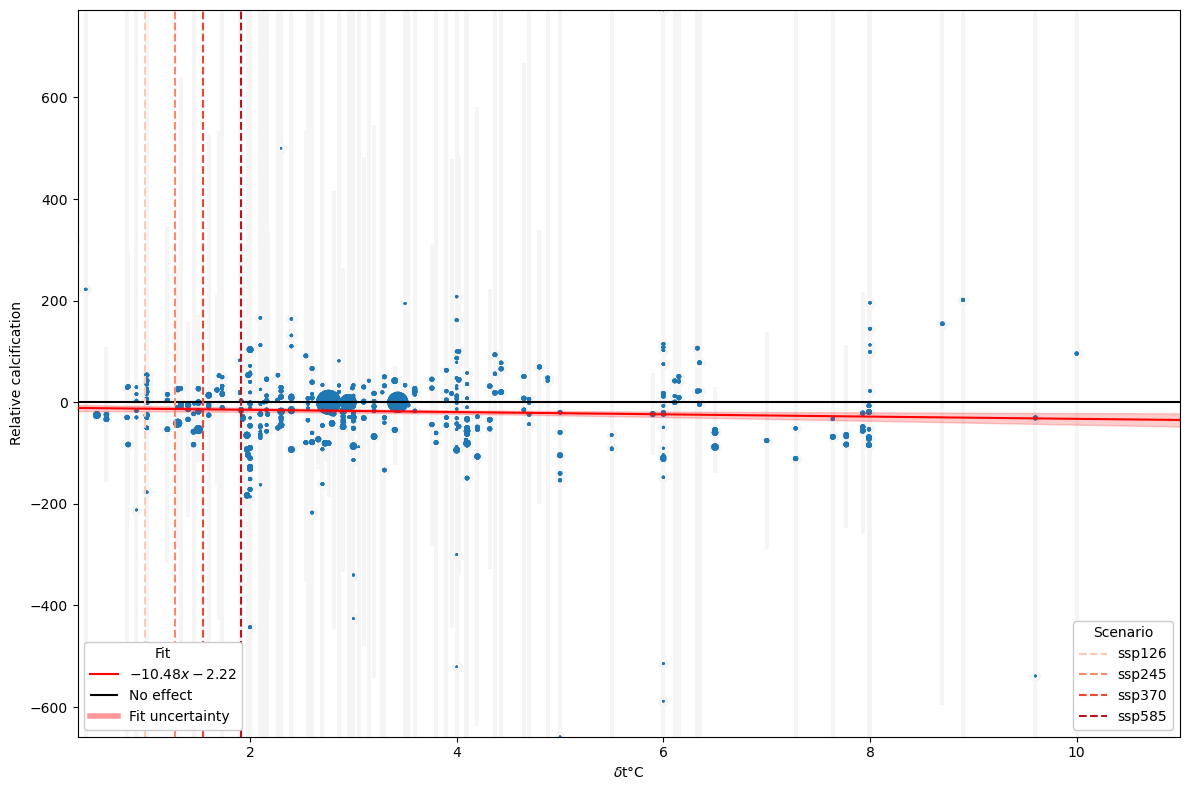

In [24]:
def exclude_outliers(df, col, threshold=3):
    """
    Exclude outliers based on the Z-score method.
    """
    mean = df[col].mean()
    std = df[col].std()
    z_scores = (df[col] - mean) / std
    return df[abs(z_scores) < threshold]

import statsmodels.api as sm

def plot_effects_vs_variable(
    df, 
    treatment_var: str=None,
    effect_type='hedges_g', 
    variable='delta_t', 
    poly_order=2,
    n_sd_ylim=5,
):
    """
    Plot the specified effect type against a variable, with optional polynomial fit.

    Parameters:
    - df (pd.DataFrame): The dataframe containing the data.
    - treatment_var (str): The treatment variable subset to filter ('temp' or 'ph').
    - effect_type (str): The effect type to plot (e.g., 'hedges_g').
    - variable (str): The variable to plot against (e.g., 'delta_t').
    - poly_order (int): The order of the polynomial fit.

    Returns:
    - None
    """
    # make a copy of the dataframe to avoid modifying the original
    # df = df.copy()
    # exclude outliers
    if n_sd_ylim:
        df = exclude_outliers(df, effect_type, threshold=n_sd_ylim)
        
    # keep first row for each hedges_g (could be any effect)
    df.copy().drop_duplicates(subset = ['hedges_g'], keep = 'first', inplace = True)
    
    # filter the dataframe based on the treatment variable
    if treatment_var:
        if treatment_var not in df.columns:
            raise ValueError(f"Treatment variable '{treatment_var}' not found in dataframe columns.")
        else:
            df = df[df['treatment'] == treatment_var]
        
    fig, ax = plt.subplots(figsize=(12, 8))

    ax.errorbar(
        df[variable], 
        df[effect_type], 
        yerr=df[f"{effect_type}_var"], 
        fmt='o', 
        color='whitesmoke', 
        alpha=0.2,
        zorder=-1,
    )
    ax.scatter(
        df[variable], 
        df[effect_type], 
        alpha=0.5,
        s=40/(df[f"{effect_type}_var"])**(1/3),
    )
    
    ax.set_ylim(df[effect_type].min(), df[effect_type].max())
    ax.set_xlim([df[variable].min() * 1.1, df[variable].max() * 1.1])
    units = "" if "ph" in variable else "°C"
    ax.set_xlabel(f"{variable.replace('delta_', r'$\Delta$').capitalize()}{units}")
    ax.set_ylabel(f"{effect_type.replace('_', ' ').capitalize()}")
    no_effect_line = ax.hlines(
        y=0, 
        xmin=df[variable].min() * 1.1,
        xmax=df[variable].max() * 1.1,
        color='black', 
        linestyle='-', 
        label='No effect'
    )   # zero effect line

    # vertical lines for warming scenarios
    scenarios = df['scenario'].unique()
    colors = sns.color_palette("Reds", len(scenarios))
    scenario_var = 'ph' if 'ph' in variable else 'sst'
    scenario_lines = []
    for i, scenario in enumerate(scenarios):
        scenario_df = df[df['scenario'] == scenario]
        line = ax.vlines(
            x=scenario_df[f'mean_{scenario_var}_20y_anomaly_ensemble'].mean(), 
            ymin=df[effect_type].min(), 
            ymax=df[effect_type].max(), 
            color=colors[i], 
            linestyle='--', 
            label=scenario, 
            # zorder=10
        )
        scenario_lines.append(line)

    fitted_model = analysis.fit_curve(
        df,
        variable, 
        effect_type, 
        order=poly_order
    )
    x_limits = ax.get_xlim()
    extended_x = np.linspace(x_limits[0], x_limits[1], 100)
    
    extended_pred, extended_lci, extended_uci = analysis.predict_curve(
        fitted_model, 
        extended_x, 
    )
    
    fit_line = ax.plot(extended_x, extended_pred, color='red', label=f"${plotting.Polynomial(fitted_model.params).__str__()}$",  zorder=101)
    uncertainty = ax.fill_between(
        extended_x,
        extended_lci, 
        extended_uci, 
        color='red', 
        alpha=0.2, 
        label='Fit uncertainty', 
        # zorder=100
    )

    # manually add legends
    first_legend = ax.legend(
        handles=scenario_lines, 
        title='Scenario', 
        loc='lower right',
        facecolor='white',
        framealpha=1,
    )
    ax.add_artist(first_legend)    
    ax.legend(
        handles=[fit_line[0], no_effect_line, plt.Line2D([0], [0], color='red', alpha=0.4, lw=4, label='Fit uncertainty')],
        title='Fit',
        loc='lower left',
        facecolor='white',
        framealpha=1,
    )   # indexing is a little hacky and not sure why line is a list
    
    plt.tight_layout()
    plt.show()

plot_effects_vs_variable(
    effects_clim_df,
    treatment_var='temp',
    effect_type='relative_calcification',
    variable='delta_t',
    poly_order=1,
    # n_sd_ylim=0.2,
)

In [25]:


fitted = analysis.fit_curve(
    effects_clim_df,
    variable='delta_ph',
    effect_type='relative_calcification',
    order=2,
)

p, l, u = analysis.predict_curve(fitted, np.linspace(-1, 0, 100))
# fitted.

In [26]:
cooks_distances = analysis.calc_cooks_distance(effects_df['hedges_g'])
cooks_threshold = analysis.calc_cooks_threshold(effects_df['hedges_g'], nparams=3)

cooks_distances[cooks_distances > cooks_threshold]

array([ 0.37777639,  0.17565593,  0.63837428,  0.14053667,  0.12425454,
        0.19126126, 31.44657749, 23.00736992,  0.39282755,  0.90978644,
        0.62090276])

## Can I do the meta-regression in python...?

In [27]:
# assign a unique index for each original_doi
effects_clim_df['doi_id'] = pd.factorize(effects_clim_df['original_doi'])[0]

import statsmodels.api as sm
import statsmodels.formula.api as smf

data = effects_clim_df.copy().drop_duplicates(subset = ['hedges_g'], keep = 'first') 
data['sample_id'] = np.arange(len(data))

# Ensure the 'doi_id' column is properly set and there are no missing values in the relevant columns
data = data.dropna(subset=['hedges_g', 'delta_t', 'doi_id'])

# Fit the mixed effects model
md = smf.mixedlm(
    "hedges_g ~ delta_t - 1",
    data=data,
    groups=data['doi_id'],
    # re_formula="1 + sample_id"
)
mdf = md.fit()

# Print the summary of the model
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: hedges_g  
No. Observations: 911     Method:             REML      
No. Groups:       104     Scale:              3.5464    
Min. group size:  1       Log-Likelihood:     -1982.0133
Max. group size:  91      Converged:          Yes       
Mean group size:  8.8                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
delta_t       -0.115    0.042 -2.754 0.006 -0.197 -0.033
Group Var      4.943    0.462                           



## Comparing

In [28]:
import pymc as pm
import arviz as az

def multilevel_meta_analysis(data, yi_col='hedges_g', v_col='hedges_g_var', mod_col='delta_ph', 
                             id_col='sample_id', doi_col='original_doi'):
    """
    Implement a multilevel meta-analysis with nested random effects
    similar to metafor's rma.mv function
    """
    data = data.dropna(subset=[yi_col, v_col, mod_col, id_col, doi_col])
    # extract variables from dataframe
    y = data[yi_col].values  # effect sizes
    v = data[v_col].values   # effect variances
    mod = data[mod_col].values  # Moderator
    
    # create IDs for random effects (nested structure)
    doi_ids = pd.Categorical(data[doi_col]).codes
    unique_dois = len(np.unique(doi_ids))
    
    # Create nested IDs
    sample_ids = pd.Categorical(data[id_col].astype(str) + "_" + data[doi_col].astype(str)).codes
    unique_samples = len(np.unique(sample_ids))
    
    print('Setting up model...')
    with pm.Model() as model:
        # Fixed effects (intercept and moderator)
        intercept = pm.Normal("intercept", mu=0, sigma=10)
        beta = pm.Normal("beta_delta_ph", mu=0, sigma=10)
        
        # Random effects for DOI level (higher level)
        sigma_doi = pm.HalfCauchy("sigma_doi", beta=5)
        doi_effects = pm.Normal("doi_effects", mu=0, sigma=sigma_doi, shape=unique_dois)
        
        # Random effects for ID within DOI (lower level)
        sigma_sample = pm.HalfCauchy("sigma_sample", beta=5)
        sample_effects = pm.Normal("sample_effects", mu=0, sigma=sigma_sample, shape=unique_samples)
        
        # Expected value
        mu = intercept + beta * mod + doi_effects[doi_ids] + sample_effects[sample_ids]
        
        # Likelihood (incorporating the known sampling variances)
        # This is equivalent to the weighting in meta-analysis
        obs = pm.Normal("obs", mu=mu, sigma=np.sqrt(v), observed=y)
        
        print('Fitting model...')
        # Sample from the posterior
        trace = pm.sample(2000, tune=1000, return_inferencedata=True, 
                          target_accept=0.9, chains=4)
    
    return model, trace

# Function to get results in a format similar to metafor's output
def summarize_results(trace, data: pd.DataFrame, v_col='hedges_g_var'):
    summary = az.summary(trace, var_names=["intercept", "beta_delta_ph", 
                                           "sigma_doi", "sigma_sample"])
    
    # Calculate I² (proportion of total variance due to heterogeneity)
    # Extract posterior samples
    samples = trace.posterior
    
    # Calculate average variance
    mean_v = np.mean(data[v_col])
    
    # Extract variance components
    sigma_dois = samples['sigma_doi'].values.flatten()
    sigma_samples = samples['sigma_sample'].values.flatten()
    
    # Calculate total variance
    total_var = sigma_dois**2 + sigma_samples**2 + mean_v
    
    # Calculate I²
    i_squared_doi = (sigma_dois**2) / total_var * 100
    i_squared_study = (sigma_samples**2) / total_var * 100
    i_squared_total = (sigma_dois**2 + sigma_samples**2) / total_var * 100
    
    # Add I² to results
    i2_results = pd.DataFrame({
        'Statistic': ['I² (DOI level)', 'I² (Study level)', 'I² (Total)'],
        'Mean': [np.mean(i_squared_doi), np.mean(i_squared_study), np.mean(i_squared_total)],
        'SD': [np.std(i_squared_doi), np.std(i_squared_study), np.std(i_squared_total)],
        '2.5%': [np.percentile(i_squared_doi, 2.5), 
                np.percentile(i_squared_study, 2.5),
                np.percentile(i_squared_total, 2.5)],
        '97.5%': [np.percentile(i_squared_doi, 97.5),
                 np.percentile(i_squared_study, 97.5),
                 np.percentile(i_squared_total, 97.5)]
    })
    
    return summary, i2_results

model, trace = multilevel_meta_analysis(
    data,
    yi_col='hedges_g',
    v_col='hedges_g_var',
    mod_col='delta_ph',
    id_col='sample_id',
    doi_col='original_doi'
    )

summarize_results(trace, data, v_col='hedges_g_var')

Setting up model...
Fitting model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_delta_ph, sigma_doi, doi_effects, sigma_sample, sample_effects]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


(                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
 intercept     -0.434  0.118  -0.654   -0.214      0.003    0.002    1383.0   
 beta_delta_ph  0.756  0.197   0.383    1.124      0.003    0.002    3348.0   
 sigma_doi      0.831  0.098   0.656    1.020      0.002    0.001    3194.0   
 sigma_sample   0.745  0.040   0.671    0.818      0.001    0.000    2025.0   
 
                ess_tail  r_hat  
 intercept        2577.0    1.0  
 beta_delta_ph    4878.0    1.0  
 sigma_doi        5194.0    1.0  
 sigma_sample     3552.0    1.0  ,
           Statistic       Mean        SD       2.5%      97.5%
 0    I² (DOI level)  36.349398  5.467647  26.246353  47.671456
 1  I² (Study level)  29.362911  3.283181  22.991271  35.809155
 2        I² (Total)  65.712309  3.103026  59.777552  71.907177)

In [30]:
bcg_data = {
    'trial': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
    'author': ['Aronson', 'Ferguson & Simes', 'Rosenthal et al', 'Hart & Sutherland', 
               'Frimodt-Moller et al', 'Stein & Aronson', 'Vandiviere et al', 'TPT Madras',
               'Coetzee & Berjak', 'Rosenthal et al', 'Comstock et al', 'Comstock & Webster',
               'Comstock et al'],
    'year': [1948, 1949, 1960, 1977, 1973, 1953, 1973, 1980, 1968, 1961, 1974, 1969, 1976],
    'tpos': [4, 6, 3, 62, 33, 180, 8, 505, 29, 17, 186, 5, 27],
    'tneg': [119, 300, 228, 13536, 5036, 1361, 2537, 87886, 7470, 1699, 50448, 2493, 16886],
    'cpos': [11, 29, 11, 248, 47, 372, 10, 499, 45, 65, 141, 3, 29],
    'cneg': [128, 274, 209, 12619, 5761, 1079, 619, 87892, 7232, 1600, 27197, 2338, 17825],
    'ablat': [44, 55, 42, 52, 13, 44, 19, 13, 27, 42, 18, 33, 33],
    'alloc': ['random', 'random', 'random', 'random', 'alternate', 'alternate', 'random', 
              'random', 'random', 'systematic', 'systematic', 'systematic', 'systematic'],
    'yi': [-0.9387, -1.6662, -1.3863, -1.4564, -0.2191, -0.9581, -1.6338, 0.0120, -0.4717, 
           -1.4012, -0.3408, 0.4466, -0.0173],
    'vi': [0.3571, 0.2081, 0.4334, 0.0203, 0.0520, 0.0099, 0.2270, 0.0040, 0.0570, 
           0.0754, 0.0125, 0.5342, 0.0716]
}

# Create the DataFrame
bcg_df = pd.DataFrame(bcg_data)

import pymc as pm
import arviz as az
from scipy import stats

def multilevel_meta_analysis(data, yi_col='hedges_g', v_col='hedges_g_var', mod_col=None, trial_col='original_doi'):
    """
    Implement a multilevel meta-analysis with nested random effects
    similar to metafor's rma.mv function
    """
    data = data.dropna(subset=[yi_col, v_col, trial_col])
    # extract variables from dataframe
    y = data[yi_col].values  # effect sizes
    v = data[v_col].values   # effect variances
    
    # create IDs for random effects (nested structure)
    trial_ids = pd.Categorical(data[trial_col]).codes
    unique_trials = len(np.unique(trial_ids))
    
    # Create nested IDs
    study_ids = pd.Categorical(data[trial_col].astype(str)).codes
    unique_studies = len(np.unique(study_ids))
    
    print('Setting up model...')
    with pm.Model() as model:
        # Fixed effects (intercept and moderator)
        # intercept = pm.Normal("intercept", mu=0, sigma=10)
        beta = pm.Normal("beta", mu=0, sigma=10)
        
        # Random effects for trial (only random level)
        sigma_trial = pm.HalfCauchy("sigma_trial", beta=5)
        trial_effects = pm.Normal("trial_effects", mu=0, sigma=sigma_trial, shape=unique_trials)
        
        # Expected value
        # mu = intercept + beta + trial_effects[trial_ids]
        mu = beta + trial_effects[trial_ids]
        
        # Likelihood (incorporating the known sampling variances)
        # This is equivalent to the weighting in meta-analysis
        obs = pm.Normal("obs", mu=mu, sigma=np.sqrt(v), observed=y)
        
        print('Fitting model...')
        # Sample from the posterior
        trace = pm.sample(5000, tune=1000, return_inferencedata=True, 
                          target_accept=0.9, chains=4)
    
    return model, trace


def summarize_results(trace, data: pd.DataFrame, v_col='hedges_g_var'):
    # conduct a Q test for heterogeneity
    q = np.sum((trace.posterior['beta'] - trace.posterior['beta'].mean())**2) / trace.posterior['sigma_trial'].mean()
    q = q / (len(data) - 1)
    p_value = 1 - stats.chi2.cdf(q, len(data) - 1)
    print(f"Q = {float(q):.06f}, p-value = {p_value}")
    
    summary = az.summary(trace, var_names=[
                        # "intercept",
                          "beta", 
                          "sigma_trial"])
    
    # Calculate I² (proportion of total variance due to heterogeneity)
    # Extract posterior samples
    samples = trace.posterior
    
    # Calculate average variance
    mean_v = np.mean(data[v_col])
    
    # Extract variance components
    sigma_trials = samples['sigma_trial'].values.flatten()
    
    # Calculate total variance
    total_var = sigma_trials**2 + mean_v
    
    # Calculate I²
    i_squared_trial = (sigma_trials**2) / total_var * 100
    # i_squared_total = (sigma_trials**2 + sigma_samples**2) / total_var * 100
    
    # Add I² to results
    i2_results = pd.DataFrame({
        'Statistic': ['I² (DOI level)'],
        'Mean': [np.mean(i_squared_trial)],
        'SD': [np.std(i_squared_trial)],
        '2.5%': [np.percentile(i_squared_trial, 2.5)],
        '97.5%': [np.percentile(i_squared_trial, 97.5)]
    })
    
    return summary, i2_results


bcg_model, bcg_trace = multilevel_meta_analysis(
    bcg_df,
    yi_col='yi',
    v_col='vi',
    trial_col='trial'
    )

summarize_results(bcg_trace, bcg_df, v_col='vi')

Initializing NUTS using jitter+adapt_diag...


Setting up model...
Fitting model...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma_trial, trial_effects]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.


Q = 114.815301, p-value = 0.0


(              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
 beta        -0.743  0.214  -1.167   -0.355      0.004    0.003    3074.0   
 sigma_trial  0.668  0.195   0.352    1.031      0.002    0.002    9725.0   
 
              ess_tail  r_hat  
 beta           4299.0    1.0  
 sigma_trial   11192.0    1.0  ,
         Statistic       Mean         SD       2.5%      97.5%
 0  I² (DOI level)  70.950618  10.713926  47.978158  88.976445)

In [31]:
bcg_model

In [32]:
### plotting against difference from climatology
# calculate difference between control temperature and historic temperature
effects_clim_df['clim_delta_t'] = effects_clim_df['temp'] - effects_clim_df['mean_historical_sst_30y_ensemble']

NameError: name 'effects_climatology_df' is not defined

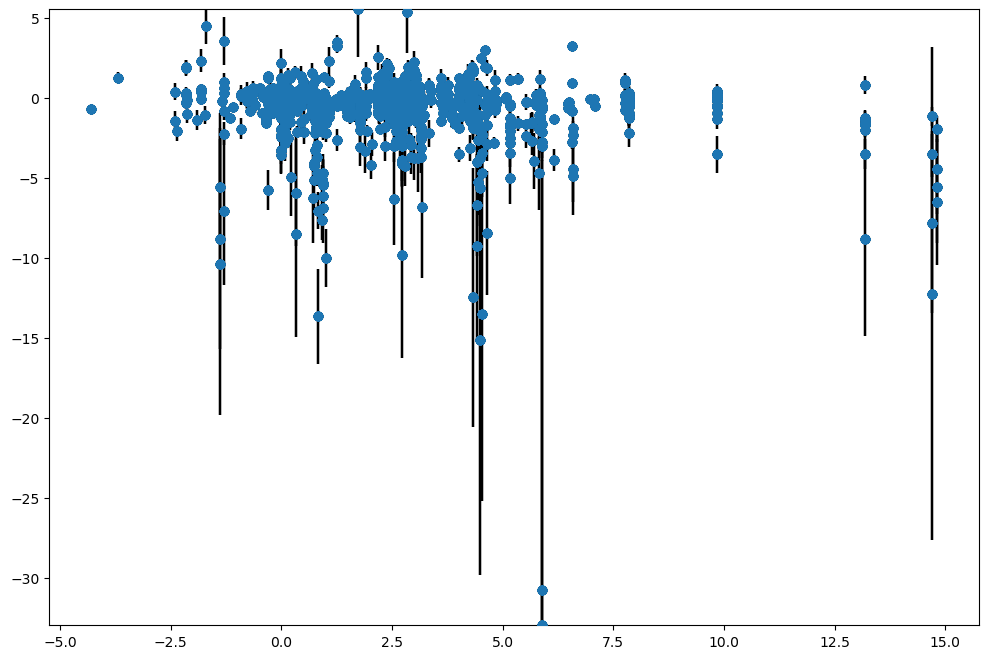

In [33]:
### plot a scatter of hedges_g against clim_delta_t
fig, ax = plt.subplots(figsize=(12, 8))

# add error bars
ax.errorbar(effects_clim_df['clim_delta_t'], effects_clim_df['hedges_g'], yerr=effects_clim_df['hedges_g_var'], fmt='o', color='black', alpha=0.5)
ax.scatter(effects_clim_df['clim_delta_t'], effects_clim_df['hedges_g'], zorder=10, alpha=0.8)

ax.set_ylim([min(effects_clim_df['hedges_g']), max(effects_clim_df['hedges_g'])])

scenarios = effects_climatology_df.scenario.unique()
colors = sns.color_palette("Reds", len(scenarios))

for i, scenario in enumerate(scenarios):
    scenario_df = effects_climatology_df[effects_climatology_df.scenario == scenario]
    # plot a vertical line at the global average historic temperature
    ax.vlines(x=scenario_df.mean_sst_20y_anomaly_ensemble.mean(), ymin=min(effects_clim_df['hedges_g']), ymax=max(effects_clim_df['hedges_g']), color=colors[i], linestyle='--', label=scenario, zorder=100)
    # add shaded area corresponding to +- 1 standard deviation
    # ax.fill_betweenx(y=[min(effects_clim_df['hedges_g']), max(effects_clim_df['hedges_g'])], x1=scenario_df.mean_sst_20y_anomaly_ensemble.mean() - scenario_df.mean_sst_20y_anomaly_ensemble.std(), x2=scenario_df.mean_sst_20y_anomaly_ensemble.mean() + scenario_df.mean_sst_20y_anomaly_ensemble.std(), color=colors[i], alpha=0.1, zorder=99)

ax.hlines(y=0, xmin=min(effects_clim_df['clim_delta_t']*1.1), xmax=max(effects_clim_df['clim_delta_t'])*1.1, color='black', linestyle='-', label='No effect')
ax.set_xlabel('Temperature Anomaly (°C)')
ax.set_ylabel('Hedges g')
ax.set_xlim([min(effects_clim_df['clim_delta_t']*1.1), max(effects_clim_df['clim_delta_t'])*1.1])
ax.legend(loc="lower right")

# plot a second-order polynomial fit
# remove nans
effects_clim_df = effects_clim_df[effects_clim_df['clim_delta_t'].notna()]
z = np.polyfit(effects_clim_df['clim_delta_t'], effects_clim_df['hedges_g'], 2)
xp = np.linspace(min(effects_clim_df['clim_delta_t']), max(effects_clim_df['clim_delta_t']), 100)
p = np.polyval(z, xp)
ax.plot(xp, p, color='red', label='2nd order polynomial fit', zorder=101)

# Next thing

In [ ]:
### load most recent all_data

# generate carbonate chemistry data
meta_fp = config.data_dir / 'Orlando_data.xlsx'
carb_df = utils.populate_carbonate_chemistry(meta_fp, 'all_data')
# carb_df = utils.uniquify_dois(carb_df)


Duplicate DOIs found, treat with caution:
['10.4319/lo.2014.59.3.1081', '10.1111/gcb.14379', '10.1016/j.jembe.2013.12.013', '10.1007/s00338-016-1425-0', '10.1007/s00227-012-2001-y']
Using locations in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/gmaps_locations.yaml
Using species mapping in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/species_mapping.yaml.
Loading measured values...
1: (3394, 82)
2: (7035, 66)
3: (3547, 64)
Calculating total pH values...
4: (3547, 64)
5: (3547, 64)
6: (3547, 33)


Calculating carbonate chemistry:   0%|          | 0/3547 [00:00<?, ?it/s]

7: (3547, 33)


AttributeError: module 'calcification.utils' has no attribute 'uniquify_dois'

In [36]:
carb_df_tgs = analysis.assign_treatment_groups_multilevel(carb_df)
results_df = analysis.calculate_effect_for_df(carb_df_tgs)
results_df.set_index('doi', inplace=True)

  0%|          | 0/163 [00:00<?, ?it/s]

## Distribution comparison between Ben's Hedges G and mine

KS test: p-value = 0.00
Distributions are different
# samples: this study = 1284, Ben's study = 329


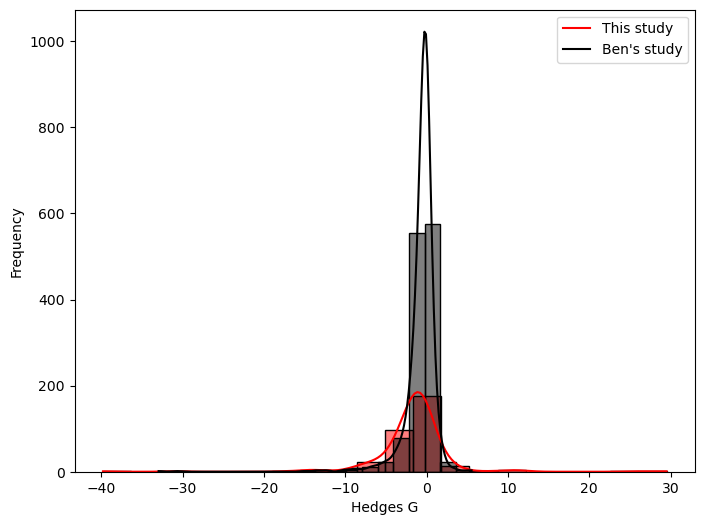

In [37]:
# TODO: investigate broadened distribution of Hedges G values: it can't all come down to changing the pooled sd

# read in all results
results_fp = config.tmp_data_dir / 'effect_sizes.csv'
results_df = pd.read_csv(results_fp, index_col=0)
# select phtot
# results_df = results_df[results_df['treatment'] == 'phtot']

# read in Ben's and concatenate
adult_fp = config.meta_dir / 'adult_raw_data(in).csv'
juvenile_fp = config.meta_dir / 'juvenile_raw_data(in).csv'

bh_df = pd.concat([pd.read_csv(fp) for fp in [adult_fp, juvenile_fp]])

# plot histogram of hedges_g values
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.histplot(bh_df['Hedges G'], bins=20, ax=ax, color='red', kde=True)
sns.histplot(results_df['hedges_g'], bins=20, ax=ax, color='black', kde=True)
# format
ax.set_xlabel('Hedges G')
ax.set_ylabel('Frequency')
ax.legend(['This study', 'Ben\'s study'])

# smirnov test for distributional similarity
from scipy.stats import ks_2samp
# remove any nans
results_df = results_df.dropna(subset=['hedges_g'])
bh_df = bh_df.dropna(subset=['Hedges G'])

ks_stats = ks_2samp(results_df['hedges_g'], bh_df['Hedges G'])
# interpret ks test
print(f"KS test: p-value = {ks_stats.pvalue:.2f}")
if ks_stats.pvalue > 0.05:
    print('Distributions are statistically similar')
else:
    print('Distributions are different')
print(f"# samples: this study = {len(results_df)}, Ben's study = {len(bh_df)}")

## Study timeseries

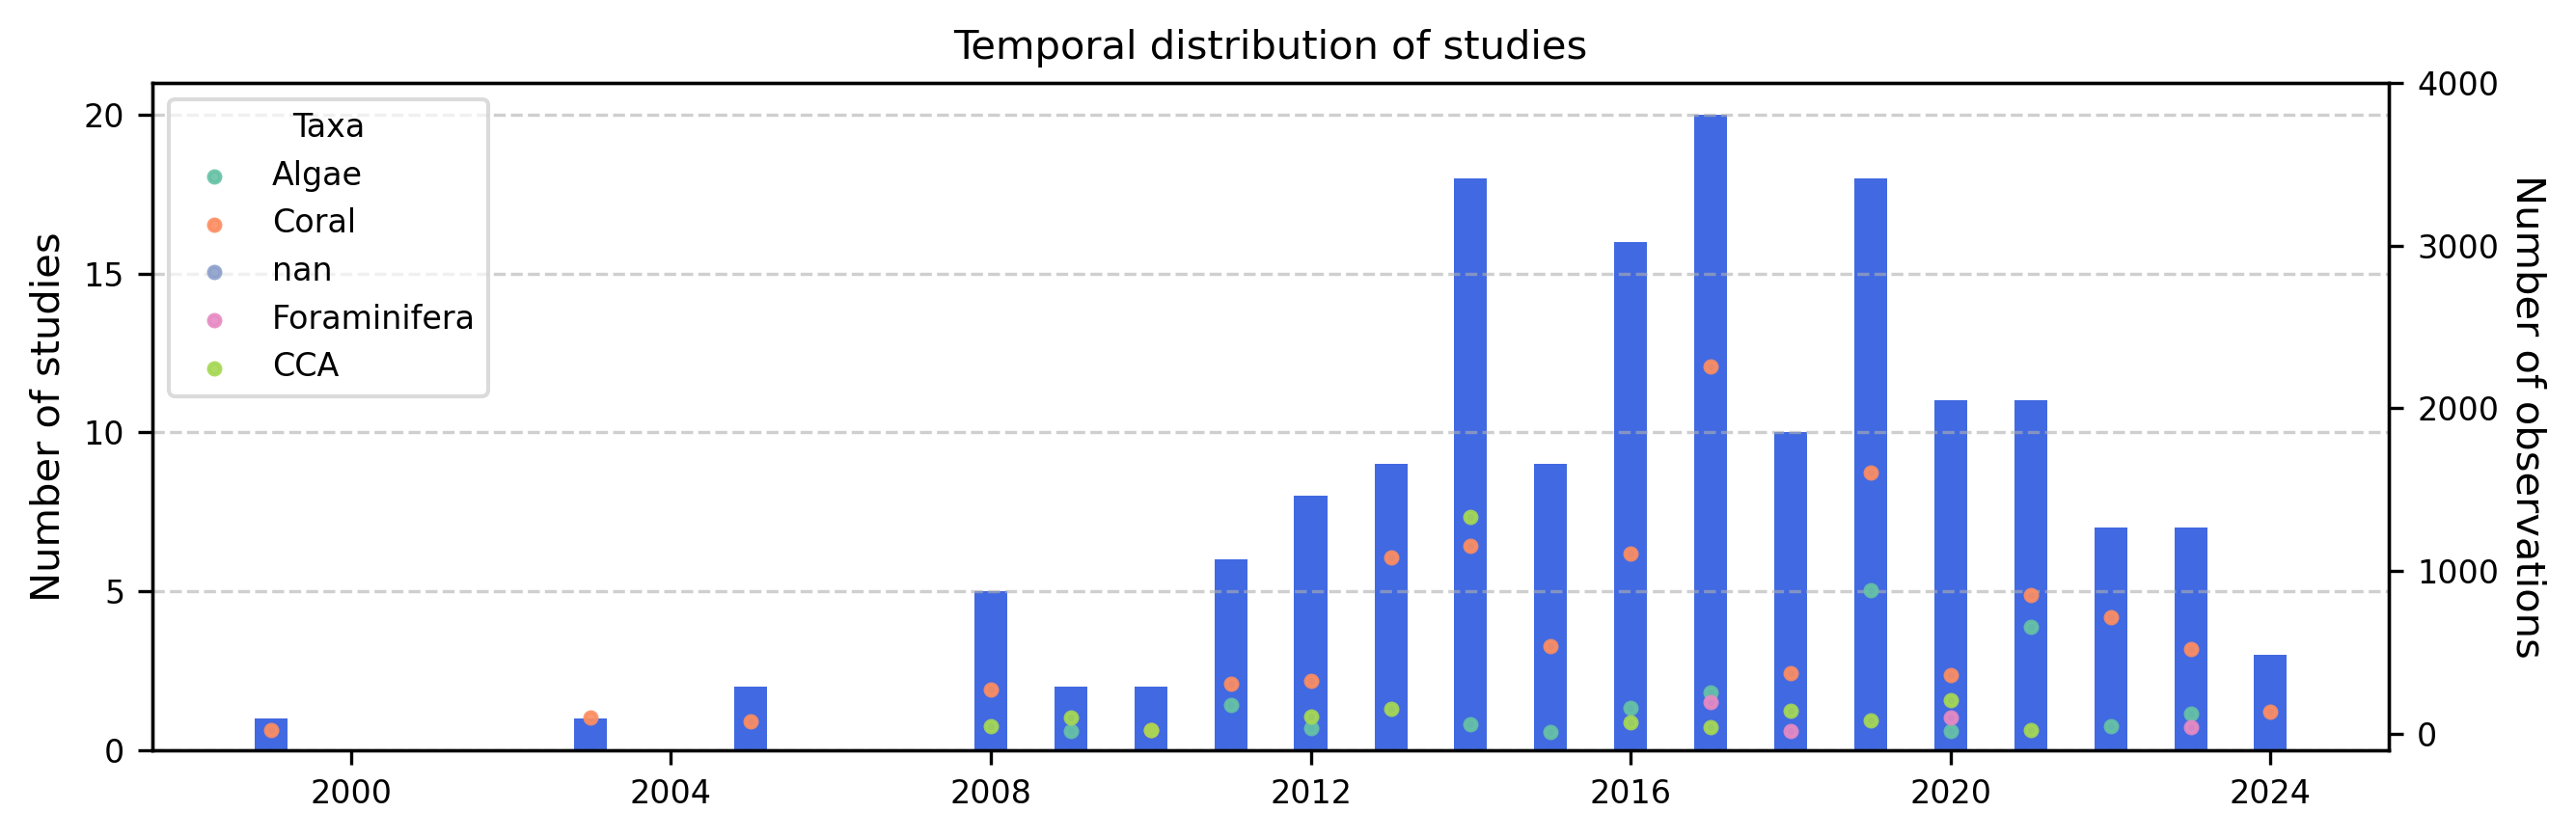

In [38]:
### plot temporal distribution of studies, breakdown by species
# create figure
fig, ax = plt.subplots(1, 1, figsize=(9, 3), dpi=300)

# drop na from year columns
dates_df = carb_df.dropna(subset=["year"])

# count occurrences of year of each doi
year_counts = carb_df.groupby('year')['doi'].nunique()

# Define smaller font size for most elements
small_fontsize = 0.8 * plt.rcParams['font.size']

# Create the bar chart
ax.bar(year_counts.index, year_counts.values, color='royalblue', width=150)
ax.set_ylabel("Number of studies", fontsize=plt.rcParams['font.size'])
ax.tick_params(axis='both', which='major', labelsize=small_fontsize)

# Set y-ticks to appear every 5 units
max_count = year_counts.max()
y_ticks = np.arange(0, max_count+5, 5)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks, fontsize=small_fontsize)

ax.grid(axis='y', linestyle='--', alpha=0.6)

# group df by taxa
taxa_df_grouped = carb_df.groupby(['taxa', 'year'])

# sum total n for each unique taxa and by year
taxa_counts = taxa_df_grouped['n'].sum()

# plot number of observations each year, by taxa
unique_taxa = carb_df['taxa'].unique()
n_ax = ax.twinx()
taxa_palette = sns.color_palette("Set2", len(unique_taxa))
taxa_color_map = dict(zip(unique_taxa, taxa_palette))

for taxa in unique_taxa:
    taxa_data = taxa_counts[taxa_counts.index.get_level_values('taxa') == taxa]
    n_ax.scatter(taxa_data.index.get_level_values('year'), taxa_data.values, 
                color=taxa_color_map[taxa], alpha=0.9, s=8, label=taxa)

n_ax.set_ylabel("Number of observations", rotation=-90, labelpad=12, fontsize=plt.rcParams['font.size'])
n_ax.tick_params(axis='y', labelsize=small_fontsize)

# TODO: align y-axis ticks with the bar chart
max_observations = taxa_counts.max()
n_yticks = np.arange(0, 4001, 1000)
n_ax.set_yticks(n_yticks)
n_ax.set_yticklabels(n_yticks, fontsize=small_fontsize)

# Create compact legend with smaller font
legend = n_ax.legend(title="Taxa",
                   loc='upper left',
                   fontsize=small_fontsize,
                   framealpha=0.7,
                   title_fontsize=small_fontsize)
legend.get_title().set_ha('left')

plt.title("Temporal distribution of studies", fontsize=plt.rcParams['font.size'])
plt.tight_layout()

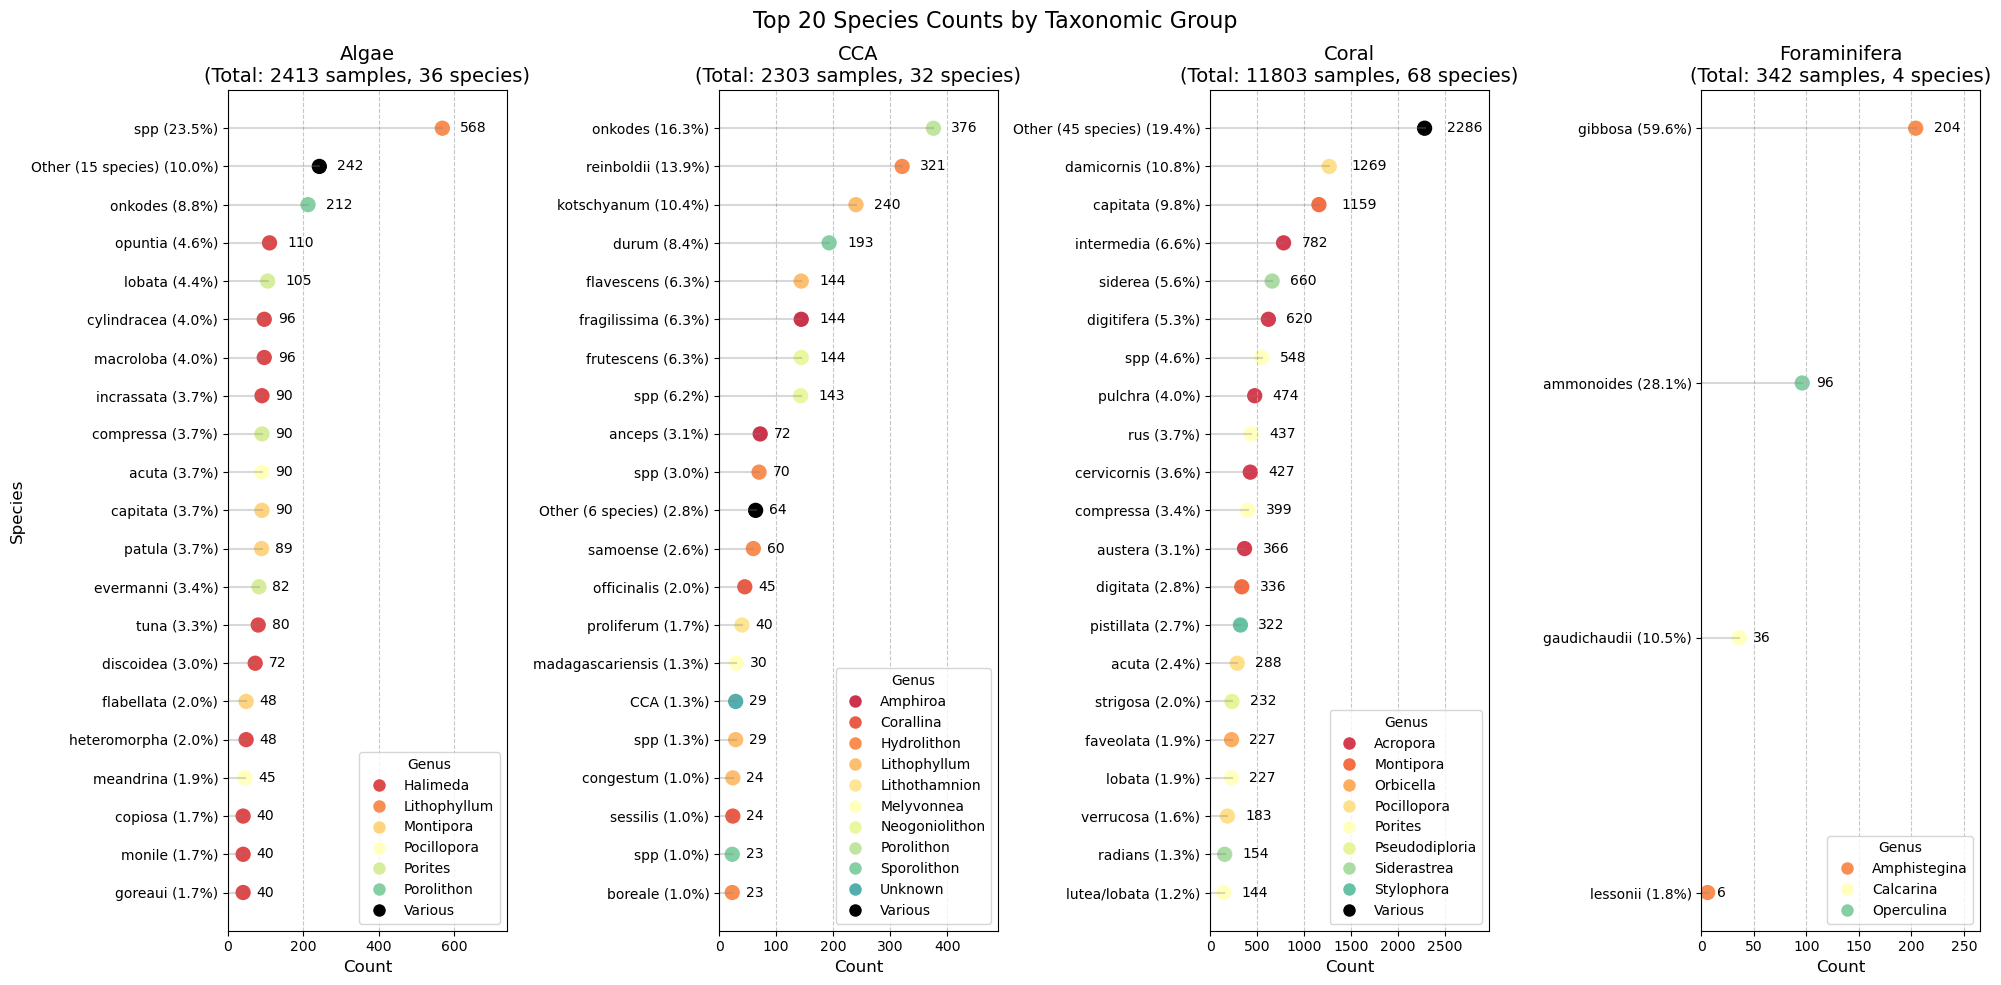

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Calculate percentage representation for "Other" category
def create_faceted_dotplot_with_percentages(carb_df, top_n):
    count_df = carb_df.groupby(['species', 'genus', 'taxa'])['n'].sum().reset_index()
    
    unique_taxa = sorted([taxa for taxa in count_df['taxa'].unique() if taxa.lower() != 'sponge'])
    n_taxa = len(unique_taxa)
    
    fig, axes = plt.subplots(1, n_taxa, figsize=(5 * n_taxa, 10), sharey=False)
    
    if n_taxa == 1:
        axes = [axes]
    
    for i, taxa in enumerate(unique_taxa):
        ax = axes[i]
        
        taxa_data = count_df[count_df['taxa'] == taxa].copy()
        total_count = taxa_data['n'].sum()
        
        taxa_data.n = taxa_data.n.astype(int)
        topn = taxa_data.nlargest(top_n, 'n')
        other_species = taxa_data[~taxa_data['species'].isin(topn['species'])]
        
        if len(other_species) > 0:
            other_count = other_species['n'].sum()
            other_percentage = (other_count / total_count) * 100
            
            other_sum = pd.DataFrame({
                'species': [f'Other ({len(other_species)} species)'],
                'genus': ['Various'],
                'taxa': [taxa],
                'n': [other_count]
            })
            
            plot_data = pd.concat([topn, other_sum], ignore_index=True)
        else:
            plot_data = topn
        
        plot_data['species_label'] = plot_data.apply(
            lambda row: f"{row['species']} ({(row['n']/total_count*100):.1f}%)", axis=1
        )
        
        plot_data = plot_data.sort_values('n', ascending=True)
        
        unique_genera = sorted(plot_data['genus'].unique())
        genus_palette = dict(zip(unique_genera, sns.color_palette("Spectral", len(unique_genera))))
        # specify 'various' genus as black
        genus_palette['Various'] = 'black'
        
        colors = [genus_palette[genus] for genus in plot_data['genus']]
        y_positions = range(len(plot_data))
        ax.scatter(plot_data['n'], y_positions, c=colors, s=100)
        
        # add count labels
        for j, (_, row) in enumerate(plot_data.iterrows()):
            ax.text(row['n'] + 0.02 * ax.get_xlim()[1] + len(str(row['n']))*0.02*ax.get_xlim()[1], j, f"{row['n']}", va='center')
        for j, (_, row) in enumerate(plot_data.iterrows()):
            ax.plot([0, row['n']], [j, j], 'gray', alpha=0.3)
        
        # formatting
        ax.set_yticks(y_positions)
        ax.set_yticklabels(plot_data['species_label'])
        max_count = plot_data['n'].max()
        ax.set_xlim(0, max_count * 1.3)  # extra space for the count labels
        ax.grid(axis='x', linestyle='--', alpha=0.7)
        ax.set_xlabel('Count', fontsize=12)
        if i == 0:
            ax.set_ylabel('Species', fontsize=12)
        # legend
        legend_handles = [Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=genus_palette[genus], markersize=10)
                         for genus in unique_genera]
        
        total_species = len(taxa_data)
        ax.set_title(f'{taxa}\n(Total: {int(total_count)} samples, {total_species} species)', fontsize=14)
        ax.legend(legend_handles, unique_genera, 
                 title='Genus', loc='lower right')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.suptitle(f'Top {int(top_n)} Species Counts by Taxonomic Group', fontsize=16)
    
    return fig

fig = create_faceted_dotplot_with_percentages(carb_df, top_n=20)


# On to other things

In [ ]:
### plot calcification rates against pH (whether Total or NBS)

# df = df[df['doi'] != '10.1007/s00338-020-01995-7']  # omit doi = 10.1007/s00338-020-01995-7 (crazy error bars)
# scale calcification rates for quick comparison
df['calcification_scaled'] = df.groupby("doi")['calcification'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
# Compute range for each study
df['calc_range'] = df.groupby("doi")['calcification'].transform(lambda x: x.max() - x.min())

# calculate standard error on mean from standard deviation and sample size
df['se'] = df.apply(lambda row: row['calcification_sd'] / row['n']**0.5 if pd.notnull(row['calcification_sd']) and pd.notnull(row['n']) else np.nan, axis=1)
# update se column with any existing calcification se values
df['se'] = df['se'].combine_first(df['calcification_se'])
# scale standard error using the same factor as calcification rates
# df['se_scaled'] = df['se'] / df['calc_range']
# df['se_scaled'] = df.apply(lambda row: row['se'] / row['calc_range']+0.1 if pd.notnull(row['calc_range']) else np.nan, axis=1)
# define marker size based on sample size
df['n'] = pd.to_numeric(df['n'], errors='coerce')  # Convert to numeric # TODO: account for 'M'
df['marker_size'] = df['n'].apply(lambda x: 10 + 60 * (x / df['n'].max()) if pd.notnull(x) else np.nan)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=300, sharey=True)
# generate a color palette
unique_dois = df['doi'].unique()
palette = sns.color_palette("husl", len(unique_dois))
doi_color_map = dict(zip(unique_dois, palette))


for ax, pH_col, title in zip(axes, ['pH_Total', 'pH_NBS'], ['pH_Total', 'pH_NBS']):
    # pH_df = df[[pH_col, 'calcification_scaled', 'se_scaled', 'marker_size', 'doi']].dropna()
    pH_df = df[[pH_col, 'calcification_scaled', 'se_scaled', 'marker_size', 'doi']]
    
    for doi in unique_dois:
        doi_df = pH_df[pH_df['doi'] == doi]
        # ax.errorbar(
        #     doi_df[pH_col], doi_df['calcification_scaled'], yerr=doi_df['se_scaled'], 
        #     fmt='o', color=doi_color_map[doi], alpha=0.5, markersize=5
        # )
        # ax.scatter(
        #     doi_df[pH_col], doi_df['calcification_scaled'], s=doi_df['marker_size'], 
        #     color=doi_color_map[doi], alpha=0.5, edgecolors='black', linewidth=0.5, label=doi
        # )
        
        ax.scatter(
            doi_df[pH_col], doi_df['calcification_scaled'],
            color=doi_color_map[doi], alpha=0.5, edgecolors='black', linewidth=0.5, label=doi
        )

    ax.set_xlabel(title, fontsize=12)
    ax.grid(True, c="lightgrey", ls=":")

axes[0].set_ylabel("Scaled calcification rate (various units)", fontsize=12)

# add legend centered below both axes
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.14), ncol=len(unique_dois)//8, fontsize=6, title="doi");

In [ ]:
### plot by taxa

ind_var = 'pH_NBS'
unique_species = df['Species_types'].unique()
fig, axes = plt.subplots(1, 3, figsize=(10, 5), dpi=300, sharey=True)
# generate a color palette
palette = sns.color_palette("husl", len(unique_species))
species_color_map = dict(zip(unique_species, palette))


for ax, taxa, title in zip(axes, ['Algae', 'Coral', 'Foraminifera'], ['Algae', 'Coral', 'Foraminifera']):
    taxa_df = df[[ind_var, 'Calcification_scaled', 'se_scaled', 'marker_size', 'Species_types']][df['Taxa'] == taxa]
    # drop nas in se_scaled and marker_size
    # taxa_df = taxa_df.dropna(subset=['se_scaled', 'marker_size'])

    
    for species in unique_species:
        species_df = taxa_df[taxa_df['Species_types'] == species]
        # ax.errorbar(
        #     species_df[species], species_df['Calcification_scaled'], yerr=species_df['se_scaled'], 
        #     fmt='o', color=doi_color_map[doi], alpha=0.5, markersize=5
        # )
        
        # ax.scatter(
        #     species_df[ind_var], species_df['Calcification_scaled'], s=species_df['marker_size'], 
        #     color=species_color_map[species], alpha=0.5, edgecolors='black', linewidth=0.5, label=species
        # )
        
        ax.scatter(
            species_df[ind_var], species_df['Calcification_scaled'],
            color=species_color_map[species], alpha=0.5, edgecolors='black', linewidth=0.5, label=species
        )

    ax.set_xlabel(title, fontsize=12)
    ax.grid(True, c="lightgrey", ls=":")

axes[0].set_ylabel("Scaled calcification rate (various units)", fontsize=12)

# add legend centered below both axes
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.14), ncol=len(unique_species)//8, fontsize=6, title="DOI");

## Investigating fitting methods

To do:
- Send Ben locations
- Convert Ben's R code into Python
- Fix dropping na by sorting out assignment of se
- ~~Linear response vs other?~~     Staying with linear: supportable
- Additionallly incorporate uncertainty in measurement of independent variable
- Measured vs unmeasured
- Standardise rate units + summarise different types
- Mixed effects
- Hierarchical modelling?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=150, sharey=True)

# generate colour pallete
unique_dois = df['DOI'].unique()
palette = sns.color_palette("husl", len(unique_dois))
doi_color_map = dict(zip(unique_dois, palette))

doi_handles, doi_labels = [], []

for ax, pH_col, title in zip(axes, ['pH_Total', 'pH_NBS'], ['pH_Total', 'pH_NBS']):
    pH_df = df[[pH_col, 'Calcification_scaled', 'se_scaled', 'marker_size', 'DOI']].dropna()
    
    # least squares regression
    xs = np.linspace(pH_df[pH_col].min(), pH_df[pH_col].max(), 100)
    m, b = np.polyfit(pH_df[pH_col], pH_df['Calcification_scaled'], 1)
    r2 = np.corrcoef(pH_df[pH_col], pH_df['Calcification_scaled'])[0, 1]**2
    # plot regression line
    ax.plot(xs, m*xs + b, color='black', alpha=0.5, linestyle='--')
    # ...and shade uncertainty bounds
    ax.fill_between(xs, m*xs + b - 2*pH_df['se_scaled'].mean(), m*xs + b + 2*pH_df['se_scaled'].mean(), 
                    color='lightgray', alpha=0.5)
    # add info to legend    
    ax.text(0.05, 0.95, f"Slope: {m:.4f}\nIntercept: {b:.2f}\nR²: {r2:.2f}", 
            transform=ax.transAxes, fontsize=10, verticalalignment='top', 
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))
    
    # add datapoints including error bars
    for doi in unique_dois:
        doi_df = pH_df[pH_df['DOI'] == doi]
        ax.errorbar(
            doi_df[pH_col], doi_df['Calcification_scaled'], yerr=doi_df['se_scaled'], 
            fmt='o', color=doi_color_map[doi], alpha=0.5, markersize=5
        )
        
        scatter = ax.scatter(
            doi_df[pH_col], doi_df['Calcification_scaled'], s=doi_df['marker_size'], 
            color=doi_color_map[doi], alpha=0.5, edgecolors='black', linewidth=0.5
        )
        
        if doi not in doi_labels:   # add only if not already in legend
            doi_handles.append(scatter)
            doi_labels.append(doi)
    
    ax.set_xlabel(title, fontsize=12)
    ax.grid(True, c="lightgrey", ls=":")

axes[0].set_ylabel("Scaled calcification rate (various units)", fontsize=12)
fig.legend(doi_handles, doi_labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=len(unique_dois)//2, fontsize=6, title="DOI")

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=150, sharey=True)

# Generate a color palette
unique_dois = df['DOI'].unique()
palette = sns.color_palette("husl", len(unique_dois))
doi_color_map = dict(zip(unique_dois, palette))

for ax, pH_col, title in zip(axes, ['pH_Total', 'pH_NBS'], ['pH_Total', 'pH_NBS']):
    pH_df = df[[pH_col, 'Calcification_scaled', 'se_scaled', 'marker_size', 'DOI']].dropna()

    # Perform weighted least squares regression (WLS)
    X = sm.add_constant(pH_df[pH_col])  # Add intercept
    y = pH_df['Calcification_scaled']
    weights = 1 / pH_df['se_scaled']**2  # Weight by inverse variance (standard error squared)

    model = sm.WLS(y, X, weights=weights).fit()
    
    # Generate fitted values and confidence intervals
    xs = np.linspace(pH_df[pH_col].min(), pH_df[pH_col].max(), 100)
    Xs = sm.add_constant(xs)  # Add intercept for prediction
    fitted_values = model.predict(Xs)
    
    # get slope and intercept of fitted values
    b, m = model.params
    r2 = np.corrcoef(pH_df[pH_col], pH_df['Calcification_scaled'])[0, 1]**2
    
    
    # Add the slope, intercept, and R² to the plot as part of the legend
    ax.text(0.05, 0.95, f"Slope: {m:.4f}\nIntercept: {b:.2f}\nR²: {r2:.2f}", 
            transform=ax.transAxes, fontsize=10, verticalalignment='top', 
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5'))
    
    
    # Compute confidence intervals
    predicted_se = np.sqrt(np.diag(model.cov_params()))  # Standard errors of the coefficients
    confidence_interval = 1.96 * predicted_se[1]  # 95% confidence interval for slope (use the second coefficient)
    
    # Plot the fitted regression line and confidence interval
    ax.plot(xs, fitted_values, color=doi_color_map[doi], alpha=0.7, linestyle='--')
    ax.fill_between(xs, fitted_values - confidence_interval, fitted_values + confidence_interval,
                    color='lightgray', alpha=0.5)
    
    for doi in unique_dois:
        doi_df = pH_df[pH_df['DOI'] == doi]
        ax.errorbar(
            doi_df[pH_col], doi_df['Calcification_scaled'], yerr=doi_df['se_scaled'], 
            fmt='o', color=doi_color_map[doi], alpha=0.5, markersize=5
        )
        
        ax.scatter(
            doi_df[pH_col], doi_df['Calcification_scaled'], s=doi_df['marker_size'], 
            color=doi_color_map[doi], alpha=0.5, edgecolors='black', linewidth=0.5, label=doi
        )

    ax.set_xlabel(title, fontsize=12)
    ax.grid(True, c="lightgrey", ls=":")
    
    if doi not in doi_labels:   # add only if not already in legend
        doi_handles.append(scatter)
        doi_labels.append(doi)

axes[0].set_ylabel("Scaled calcification rate (various units)", fontsize=12)

# Add legend centered below both axes
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(doi_handles, doi_labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=len(unique_dois)//2, fontsize=6, title="DOI")

plt.show()
# N.B. accounting for uncertainty in measured values makes a major difference: compare the slopes

### Work in progress

In [ ]:
import statsmodels.api as sm

pH_col = 'pH_Total'
pH_df = df.dropna(subset=[pH_col, 'Calcification_scaled', 'se_scaled'])

X = sm.add_constant(pH_df[pH_col])  # add constant (intercept) term
y = pH_df['Calcification_scaled']   # dependent variable (response)

weights = 1 / 10*pH_df['se_scaled']**2  # calculate the weights (inverse of the squared standard errors). N.B. 10 is a heuristic scaling factor to prevent weight explosion
# adjust X and y for the weights (multiply by sqrt(weights))
X_weighted = X * np.sqrt(np.array(weights))[:, np.newaxis]
y_weighted = y * np.sqrt(np.array(weights))

model = sm.GLS(y_weighted, X_weighted).fit()
print(f"Results for {pH_col}:")
print(model.summary())

In [ ]:
# Get the fitted values
pH_df.loc[:, 'fitted_values'] = model.fittedvalues

# Plotting the relationship
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pH_df[pH_col], y=pH_df['Calcification_scaled'], color='royalblue', alpha=0.5, label='Data')

# Plot the regression line (fitted values)
plt.plot(pH_df[pH_col], pH_df['fitted_values'], color='red', label='Fitted line', linewidth=2)

# Calculate the standard errors of the fitted values
predicted_se = np.sqrt(np.diag(model.cov_params()))

# Confidence interval (95%)
confidence_interval = 1.96 * predicted_se

# # Calculate the upper and lower bounds for the fitted values
# upper_bound = pH_df['fitted_values'] + confidence_interval
# lower_bound = pH_df['fitted_values'] - confidence_interval

# # Plot the confidence intervals as a shaded region
# plt.fill_between(pH_df[pH_col], lower_bound, upper_bound, color='red', alpha=0.2, label='95% Confidence Interval')

# Add labels and title
plt.xlabel(f'{pH_col} (Total)', fontsize=12)
plt.ylabel('Scaled Calcification Rate', fontsize=12)
plt.title(f'Relationship between {pH_col} and Scaled Calcification Rate', fontsize=14)
plt.legend()
plt.grid(True, linestyle=':', color='lightgrey')

# Show the plot
plt.show()